In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.linalg import pinv, eigvals, norm
from sklearn.metrics import mean_squared_error

Iteration 1, Norm Difference: 11.461148298247565
Iteration 2, Norm Difference: 11.470839179060857
Iteration 3, Norm Difference: 11.468904327381066
Iteration 4, Norm Difference: 11.467431649112854
Iteration 5, Norm Difference: 11.467941825807014
Iteration 6, Norm Difference: 11.467748850935232
Iteration 7, Norm Difference: 11.467502034315155
Iteration 8, Norm Difference: 11.466414118591418
Iteration 9, Norm Difference: 11.466160342174028
Iteration 10, Norm Difference: 11.465979632762284
Learned Laplacian:
 [[ 5.97014925e+00 -3.80972123e-04 -9.95484628e-01  3.34190308e-04
  -9.95040393e-01 -3.95161546e-04  3.30322134e-04 -1.06078576e-04
  -5.34995170e-04 -9.92984718e-01  1.02367470e-04 -9.96559420e-01
  -9.95815647e-01 -3.61736184e-04  3.39177930e-04  4.64181564e-04
   8.47974292e-04 -2.90088940e-04 -9.94276477e-01 -3.62757726e-04]
 [ 3.75367415e-06  3.64296486e+00  1.03311656e+00  4.00913243e-01
  -8.41604158e-01 -2.76936200e-01  6.60485382e-01  1.27193138e-01
  -2.24647037e-01  4.13877

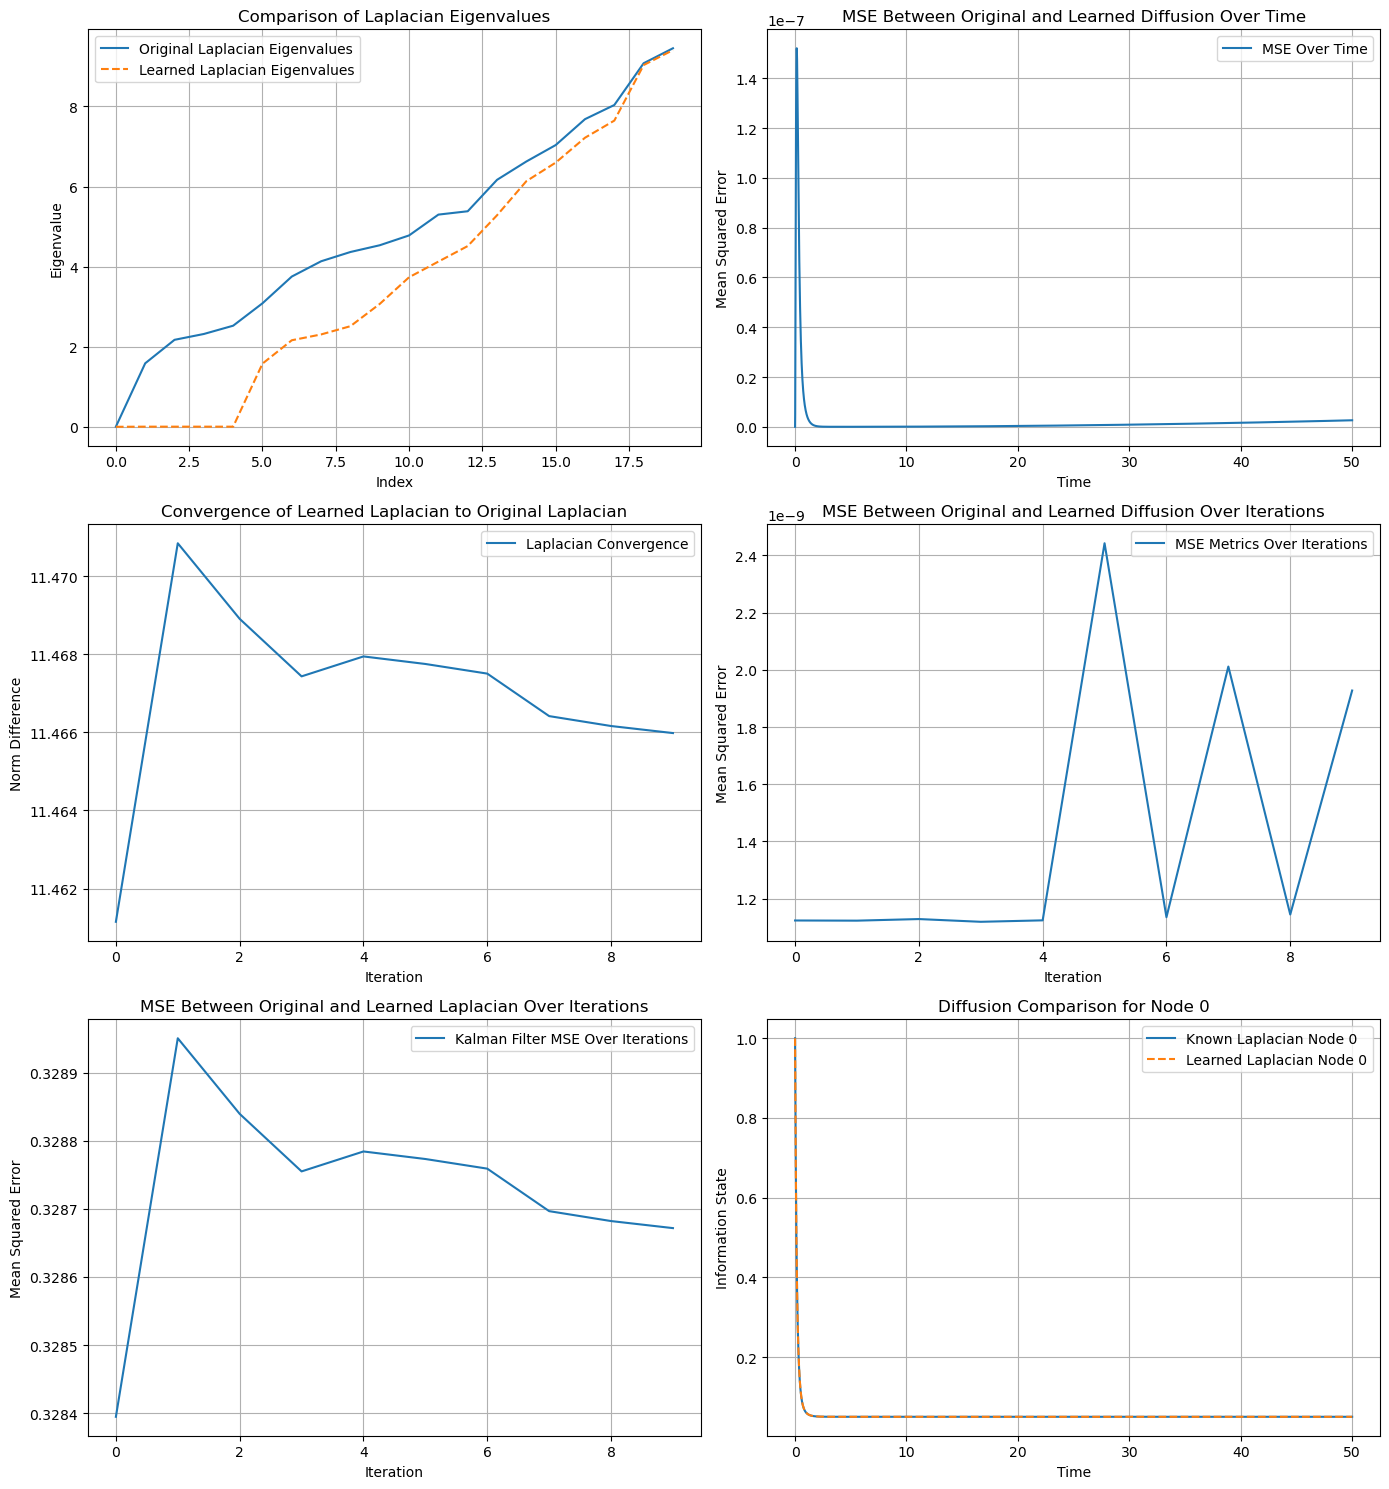

In [5]:

# Function to create a graph and compute its Laplacian
def create_graph(n, p):
    G = nx.erdos_renyi_graph(n, p)
    L = nx.laplacian_matrix(G).toarray()  # Ensure it's a dense array
    return G, L

# Function to simulate diffusion process
def simulate_diffusion(L, u0, T=50, dt=0.01):
    num_steps = int(T / dt)
    u = np.zeros((num_steps + 1, len(u0)))
    u[0] = u0
    for t in range(1, num_steps + 1):
        u[t] = u[t - 1] - dt * L @ u[t - 1]
    return u

# Function to learn Laplacian
def learn_laplacian(X, y):
    L_learned = pinv(X) @ y
    return L_learned

# Function to validate the learned Laplacian
def validate_laplacian(u, u_learned):
    mse = mean_squared_error(u, u_learned)
    return mse

# Function to plot eigenvalues
def plot_eigenvalues(ax, L, L_learned):
    eigvals_original = eigvals(L)
    eigvals_learned = eigvals(L_learned)

    ax.plot(np.sort(eigvals_original.real), label='Original Laplacian Eigenvalues')
    ax.plot(np.sort(eigvals_learned.real), label='Learned Laplacian Eigenvalues', linestyle='--')
    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Comparison of Laplacian Eigenvalues')
    ax.legend()
    ax.grid(True)

# Function to plot MSE over time
def plot_mse_over_time(ax, u, u_learned, dt):
    mse_over_time = np.mean((u - u_learned)**2, axis=1)

    ax.plot(np.arange(len(mse_over_time)) * dt, mse_over_time, label='MSE Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title('MSE Between Original and Learned Diffusion Over Time')
    ax.legend()
    ax.grid(True)

# Function to plot convergence
def plot_convergence(ax, convergence_metrics):
    ax.plot(convergence_metrics, label='Laplacian Convergence')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Norm Difference')
    ax.set_title('Convergence of Learned Laplacian to Original Laplacian')
    ax.legend()
    ax.grid(True)

# Kalman Filter functions
def kalman_filter_update(L_pred, P_pred, H, z, R):
    # Kalman gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    # Update estimate
    L_updated = L_pred + K @ (z - H @ L_pred)
    # Update error covariance
    P_updated = (np.eye(len(P_pred)) - K @ H) @ P_pred
    return L_updated, P_updated

# Main function to run the simulation and validation
def main():
    # Define a general graph structure with more nodes
    n = 20  # number of nodes
    p = 0.2  # probability of edge creation
    G, L = create_graph(n, p)

    # Define initial state vector
    u0 = np.zeros(n)
    u0[0] = 1  # Initially, only the first node has the information

    # Simulate diffusion process on the first network using the known Laplacian
    T = 50
    dt = 0.01
    u = simulate_diffusion(L, u0, T, dt)

    # Generate training data
    X = []
    y = []
    num_steps = len(u) - 1
    for t in range(num_steps):
        X.append(u[t])
        y.append((u[t] - u[t+1]) / dt)

    X = np.array(X)
    y = np.array(y)

    # Initial Kalman Filter parameters
    L_learned = np.zeros_like(L)
    P = np.eye(L.shape[0])  # Initial error covariance
    H = np.eye(L.shape[0])  # Observation model
    R = np.eye(L.shape[0]) * 0.01  # Observation noise covariance

    # Iteratively learn the Laplacian using Kalman filter
    num_iterations = 10
    convergence_metrics = []
    mse_metrics = []
    kalman_filter_mse_metrics = []

    for i in range(num_iterations):
        # Prediction step
        L_pred = L_learned
        P_pred = P + np.eye(L.shape[0])  # Process noise is identity for simplicity

        # Update step with observations
        L_learned, P = kalman_filter_update(L_pred, P_pred, H, learn_laplacian(X, y), R)
        norm_diff = norm(L - L_learned)
        convergence_metrics.append(norm_diff)
        print(f'Iteration {i+1}, Norm Difference: {norm_diff}')

        # Evaluate Kalman filter accuracy (MSE between learned and original Laplacian)
        kalman_filter_mse = mean_squared_error(L, L_learned)
        kalman_filter_mse_metrics.append(kalman_filter_mse)
        
        # Simulate with the learned Laplacian for next iteration
        u_learned = simulate_diffusion(L_learned, u0, T, dt)
        mse = validate_laplacian(u, u_learned)
        mse_metrics.append(mse)
        
        X = []
        y = []
        for t in range(num_steps):
            X.append(u_learned[t])
            y.append((u_learned[t] - u_learned[t+1]) / dt)
        X = np.array(X)
        y = np.array(y)

    print("Learned Laplacian:\n", L_learned)
    print("Original Laplacian:\n", L)

    # Validate the learned Laplacian
    u_learned = simulate_diffusion(L_learned, u0, T, dt)
    final_mse = validate_laplacian(u, u_learned)
    print(f'Final Mean Squared Error: {final_mse}')

    # Simulate diffusion on the second network using the learned Laplacian
    u_learned = simulate_diffusion(L_learned, u0, T, dt)

    # Set up the grid for plotting
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))

    # Plot eigenvalues
    plot_eigenvalues(axs[0, 0], L, L_learned)

    # Plot MSE over time
    plot_mse_over_time(axs[0, 1], u, u_learned, dt)

    # Plot convergence
    plot_convergence(axs[1, 0], convergence_metrics)

    # Plot MSE metrics over iterations
    axs[1, 1].plot(mse_metrics, label='MSE Metrics Over Iterations')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('Mean Squared Error')
    axs[1, 1].set_title('MSE Between Original and Learned Diffusion Over Iterations')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Plot Kalman filter MSE metrics over iterations
    axs[2, 0].plot(kalman_filter_mse_metrics, label='Kalman Filter MSE Over Iterations')
    axs[2, 0].set_xlabel('Iteration')
    axs[2, 0].set_ylabel('Mean Squared Error')
    axs[2, 0].set_title('MSE Between Original and Learned Laplacian Over Iterations')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Plot the diffusion comparison
    axs[2, 1].plot(np.arange(len(u)) * dt, u[:, 0], label='Known Laplacian Node 0')
    axs[2, 1].plot(np.arange(len(u_learned)) * dt, u_learned[:, 0], label='Learned Laplacian Node 0', linestyle='--')
    axs[2, 1].set_xlabel('Time')
    axs[2, 1].set_ylabel('Information State')
    axs[2, 1].set_title('Diffusion Comparison for Node 0')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()
